# **Project Name**  - Multiclass Fish Image Classification


##### **Project Type**   - Deep Learning
##### **Contribution**   - Individual
##### **Team Member 1 -**  Gade Pavan Kumar Reddy

# **Project Summary -**

This project addresses the growing need for efficient, accurate, and scalable identification of fish species from underwater images—a task vital for marine biology research, fisheries management, and environmental monitoring. Manual identification is labor-intensive and often prone to errors, especially with large, diverse datasets and challenging imaging conditions common in aquatic environments. By leveraging deep learning, particularly Convolutional Neural Networks (CNNs) and transfer learning, the project aims to automate and enhance fish species classification across 11 distinct classes.

The dataset comprised over 10,000 manually labeled images, divided into training, validation, and test sets while ensuring adequate class representation and separation. Initial data preprocessing included resizing, normalization, and augmentation (random flips, rotations, and zooms) to improve model generalization and account for real-world image variability.

A custom CNN was designed and evaluated as a baseline, followed by experiments with several popular transfer learning models: VGG16, ResNet50, MobileNet, InceptionV3, and EfficientNetB0. All models were trained and validated with careful hyperparameter tuning, early stopping, and adaptive learning rate scheduling to maximize accuracy and minimize overfitting. Evaluation on a reserved test set used multiple metrics—including accuracy, precision, recall, F1-score, and confusion matrices—to ensure robust performance assessment.

The results demonstrate a clear advantage for transfer learning approaches, with MobileNet achieving outstanding accuracy (~98.6%) and balanced high scores across all metrics, outperforming both the custom CNN and other pretrained models. Class-wise analysis and confusion matrices highlighted that some species, especially those with fewer samples, remain challenging and may benefit from targeted data augmentation or additional data collection.

This work culminated in the deployment of the best-performing model through a user-friendly Streamlit application, making advanced fish species identification accessible and practical for end-users.

# **GitHub Link -**

Link - https://github.com/pavangade31/Muticlass-Fish-Classification

# **Problem Statement**

The project aims to develop an accurate image classification system to identify and classify multiple species of fish from underwater images. This is crucial for applications in marine biology, fisheries management, and environmental monitoring, where manual identification is time-consuming and error-prone. Using deep learning and convolutional neural networks (CNNs), the model learns distinctive visual features from a diverse dataset of fish images spanning various species. The challenge lies in handling intra-class variations, lighting conditions, and background complexities typical in aquatic environments. By leveraging transfer learning with pre-trained models and custom CNN architectures, the system seeks to optimize classification accuracy, robustness, and computational efficiency. The final solution will provide a scalable tool to automate fish species detection, facilitating quick and reliable data collection for research, conservation, and commercial purposes.

# ***Let's Begin !***

## Step 1: Imports & Configuration

In [ ]:
# Mount Google Drive to access data and save models
from google.colab import drive
drive.mount('/content/drive')
# Copy your dataset from Google Drive to Colab's local disk for MUCH faster data loading
!cp -r "/content/drive/My Drive/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data" /content/

# Now set the data directory to point to the copy in local disk, not Drive
DATA_DIR = "/content/data"
MODEL_SAVE_PATH = "/content/drive/My Drive/Labmentix Projects/3.Multi Class Fish Classification"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras import applications
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

## Step 2: Dataset Paths and Class Names

In [ ]:
CLASS_NAMES = [
    "animal fish", "animal fish bass", "fish sea_food black_sea_sprat",
    "fish sea_food gilt_head_bream", "fish sea_food hourse_mackerel",
    "fish sea_food red_mullet", "fish sea_food red_sea_bream",
    "fish sea_food sea_bass", "fish sea_food shrimp",
    "fish sea_food striped_red_mullet", "fish sea_food trout"
]

train_dir = os.path.join(DATA_DIR, "train")
val_dir = os.path.join(DATA_DIR, "val")
test_dir = os.path.join(DATA_DIR, "test")

IMG_SIZE = (150, 150)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

## Step 3: Data Generators

In [ ]:
def get_dataset(directory, training=False):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        class_names=CLASS_NAMES,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=training
    )
    normalization_layer = layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    if training:
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = get_dataset(train_dir, training=True)
val_ds = get_dataset(val_dir, training=False)
test_ds = get_dataset(test_dir, training=False)

Found 6225 files belonging to 11 classes.
Found 1092 files belonging to 11 classes.
Found 3187 files belonging to 11 classes.


## Step 4: Define Custom CNN Model

In [ ]:
def create_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

custom_cnn = create_custom_cnn(IMG_SIZE + (3,), len(CLASS_NAMES))
custom_cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,179 (434.29 KB)

 Trainable params: 111,179 (434.29 KB)

 Non-trainable params: 0 (0.00 B)

## Step 5: Callbacks for Training

In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-6)

## Step 6: Train the Custom CNN Model

In [ ]:
custom_cnn_history = custom_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

custom_cnn.save(os.path.join(MODEL_SAVE_PATH, "custom_cnn.h5"))

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - accuracy: 0.8736 - loss: 0.3772 - val_accuracy: 0.8755 - val_loss: 0.3822 - learning_rate: 4.0000e-05
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 39s 200ms/step - accuracy: 0.8720 - loss: 0.3694 - val_accuracy: 0.8672 - val_loss: 0.4013 - learning_rate: 4.0000e-05
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 34s 174ms/step - accuracy: 0.8707 - loss: 0.3669 - val_accuracy: 0.8571 - val_loss: 0.3995 - learning_rate: 4.0000e-05
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.8825 - loss: 0.3601 - val_accuracy: 0.8507 - val_loss: 0.4304 - learning_rate: 4.0000e-05
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - accuracy: 0.8850 - loss: 0.3477 - val_accuracy: 0.8544 - val_loss: 0.4327 - learning_rate: 8.0000e-06
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - accuracy: 0.8790 - loss: 0.3505 - val_accuracy: 0.8553 - val_loss: 0.4237 - learning_rate: 8.0000e-06


## Step 7: Transfer Learning Models Training and Training Accuracy Comparison

In [ ]:
def create_transfer_model(base_model_name, input_shape, num_classes):
    base_models = {
        "VGG16": applications.VGG16,
        "ResNet50": applications.ResNet50,
        "MobileNet": applications.MobileNet,
        "InceptionV3": applications.InceptionV3,
        "EfficientNetB0": applications.EfficientNetB0
    }
    base_model_func = base_models.get(base_model_name)
    if base_model_func is None:
        raise ValueError(f"Unknown model name: {base_model_name}")

    base_model = base_model_func(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze for initial training

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_names = ["VGG16", "ResNet50", "MobileNet", "InceptionV3", "EfficientNetB0"]
results = []
histories = {}
for name in model_names:
    print(f"Training {name} transfer learning model...")
    tl_model = create_transfer_model(name, IMG_SIZE + (3,), len(CLASS_NAMES))
    history = tl_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        callbacks=[early_stop, reduce_lr]
    )
    histories[name] = history
    model_path = os.path.join(MODEL_SAVE_PATH, f"{name}_transfer.h5")
    tl_model.save(model_path)
    best_val_acc = max(history.history['val_accuracy'])
    results.append({"Model": name, "Best Validation Accuracy": best_val_acc})

results_df = pd.DataFrame(results)
print("\nTransfer Learning Models Validation Accuracy:")
print(results_df)

Training VGG16 transfer learning model...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 49s 225ms/step - accuracy: 0.3605 - loss: 1.8948 - val_accuracy: 0.7381 - val_loss: 1.0142 - learning_rate: 0.0010
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - accuracy: 0.6826 - loss: 0.9909 - val_accuracy: 0.8489 - val_loss: 0.6612 - learning_rate: 0.0010
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 42s 213ms/step - accuracy: 0.7729 - loss: 0.7350 - val_accuracy: 0.8599 - val_loss: 0.5330 - learning_rate: 0.0010
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - accuracy: 0.7930 - loss: 0.6199 - val_accuracy: 0.8874 - val_loss: 0.4310 - learning_rate: 0.0010
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.8264 - loss: 0.5352 - val_accuracy: 0.9057 - val_loss: 0.3687 - learning_rate: 0.0010


Training ResNet50 transfer learning model...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 65s 247ms/step - accuracy: 0.1518 - loss: 2.3695 - val_accuracy: 0.1685 - val_loss: 2.2583 - learning_rate: 0.0010
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - accuracy: 0.1851 - loss: 2.2665 - val_accuracy: 0.1960 - val_loss: 2.1814 - learning_rate: 0.0010
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 36s 184ms/step - accuracy: 0.2040 - loss: 2.1963 - val_accuracy: 0.2491 - val_loss: 2.0985 - learning_rate: 0.0010
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 39s 201ms/step - accuracy: 0.2208 - loss: 2.1312 - val_accuracy: 0.2866 - val_loss: 2.0311 - learning_rate: 0.0010
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.2478 - loss: 2.0809 - val_accuracy: 0.3150 - val_loss: 1.9871 - learning_rate: 0.0010


Training MobileNet transfer learning model...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 49s 213ms/step - accuracy: 0.6007 - loss: 1.3934 - val_accuracy: 0.9570 - val_loss: 0.1537 - learning_rate: 0.0010
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 71s 173ms/step - accuracy: 0.9119 - loss: 0.2898 - val_accuracy: 0.9679 - val_loss: 0.1053 - learning_rate: 0.0010
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 35s 179ms/step - accuracy: 0.9295 - loss: 0.2064 - val_accuracy: 0.9716 - val_loss: 0.0968 - learning_rate: 0.0010
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - accuracy: 0.9512 - loss: 0.1536 - val_accuracy: 0.9771 - val_loss: 0.0628 - learning_rate: 0.0010
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 43s 183ms/step - accuracy: 0.9539 - loss: 0.1265 - val_accuracy: 0.9853 - val_loss: 0.0485 - learning_rate: 0.0010


Training InceptionV3 transfer learning model...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 71s 281ms/step - accuracy: 0.5119 - loss: 1.5392 - val_accuracy: 0.8297 - val_loss: 0.5076 - learning_rate: 0.0010
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - accuracy: 0.7920 - loss: 0.6219 - val_accuracy: 0.9103 - val_loss: 0.2879 - learning_rate: 0.0010
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 38s 180ms/step - accuracy: 0.8389 - loss: 0.4673 - val_accuracy: 0.9167 - val_loss: 0.2373 - learning_rate: 0.0010
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - accuracy: 0.8610 - loss: 0.3983 - val_accuracy: 0.9377 - val_loss: 0.2067 - learning_rate: 0.0010
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - accuracy: 0.8760 - loss: 0.3438 - val_accuracy: 0.9560 - val_loss: 0.1474 - learning_rate: 0.0010


Training EfficientNetB0 transfer learning model...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 87s 308ms/step - accuracy: 0.1559 - loss: 2.3625 - val_accuracy: 0.1712 - val_loss: 2.3191 - learning_rate: 0.0010
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 35s 178ms/step - accuracy: 0.1685 - loss: 2.3190 - val_accuracy: 0.1712 - val_loss: 2.3114 - learning_rate: 0.0010
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - accuracy: 0.1782 - loss: 2.3101 - val_accuracy: 0.1712 - val_loss: 2.3125 - learning_rate: 0.0010
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - accuracy: 0.1808 - loss: 2.3003 - val_accuracy: 0.1712 - val_loss: 2.3126 - learning_rate: 0.0010
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 43s 195ms/step - accuracy: 0.1762 - loss: 2.3047 - val_accuracy: 0.1712 - val_loss: 2.3132 - learning_rate: 0.0010



Transfer Learning Models Validation Accuracy:
            Model  Best Validation Accuracy
0           VGG16                  0.905678
1        ResNet50                  0.315018
2       MobileNet                  0.985348
3     InceptionV3                  0.956044
4  EfficientNetB0                  0.171245


## Step 8: Plot Training and Validation Accuracy and Loss

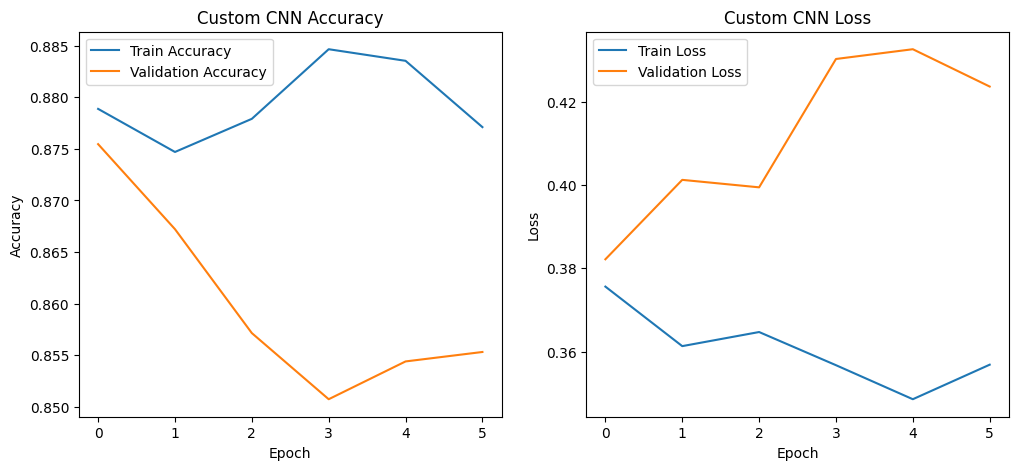

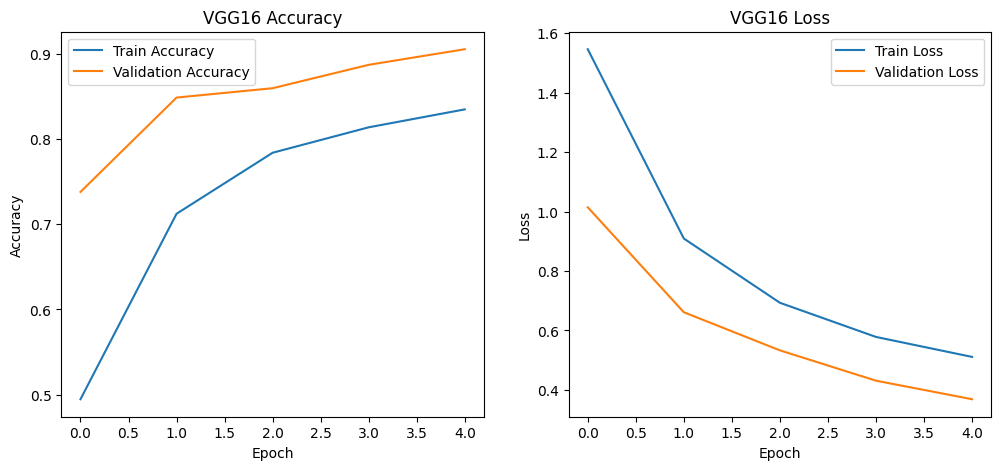

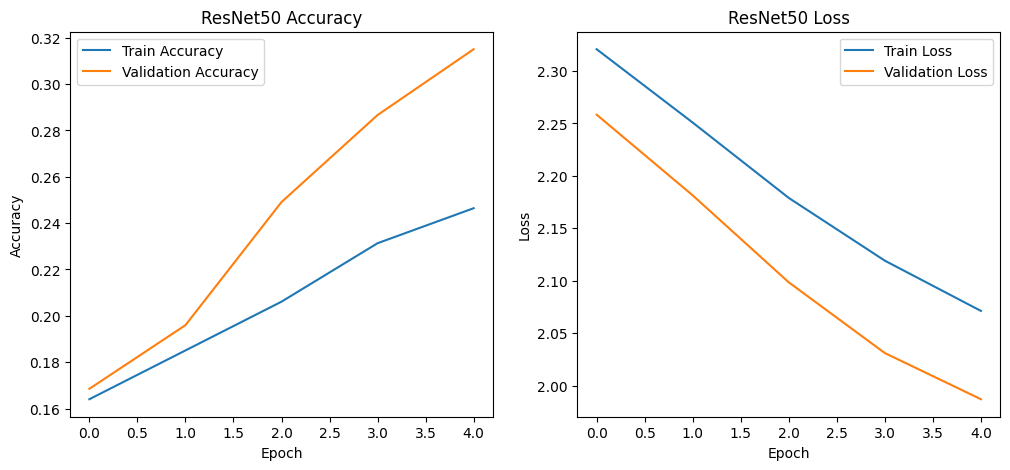

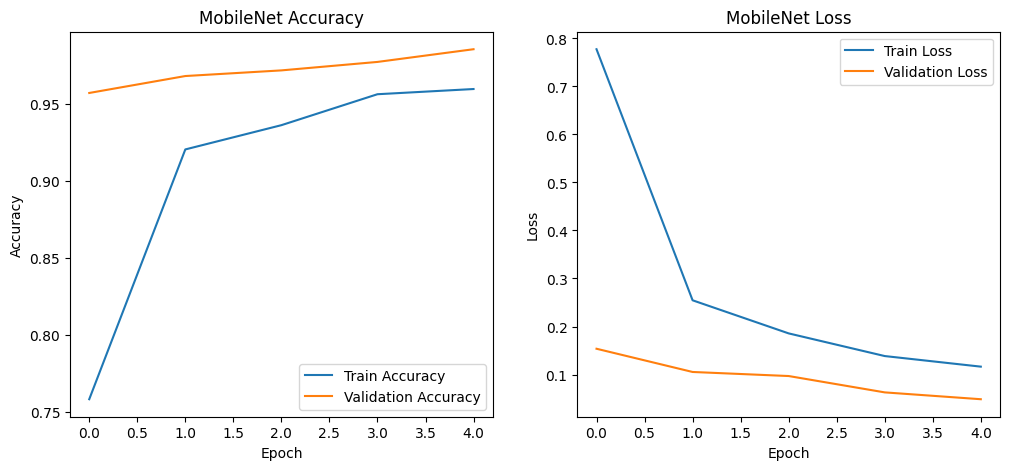

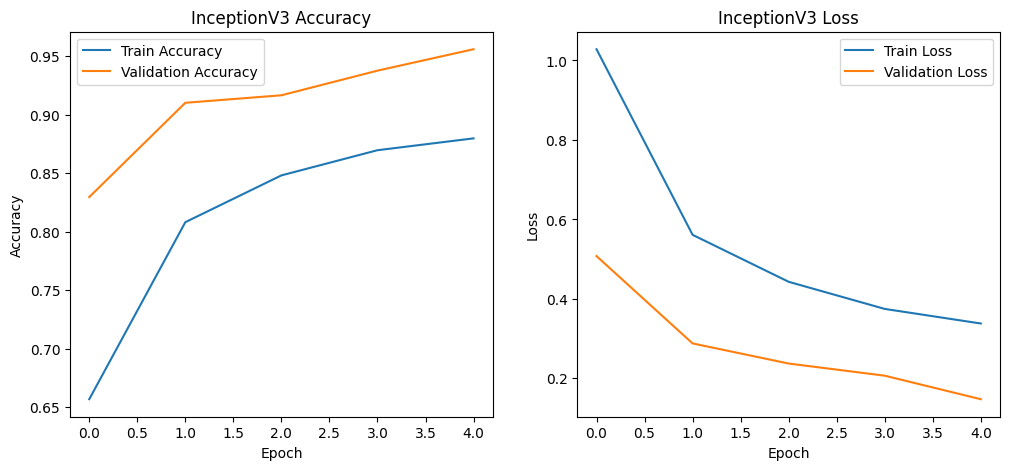

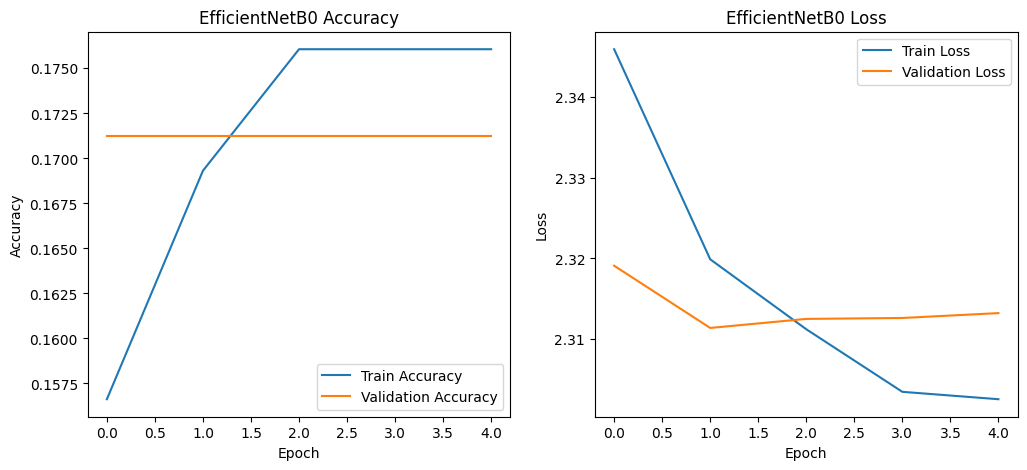

In [ ]:
def plot_history(history, model_name):
    plt.figure(figsize=(12,5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


plot_history(custom_cnn_history, 'Custom CNN')
plot_history(histories['VGG16'], 'VGG16')
plot_history(histories['ResNet50'], 'ResNet50')
plot_history(histories['MobileNet'], 'MobileNet')
plot_history(histories['InceptionV3'], 'InceptionV3')
plot_history(histories['EfficientNetB0'], 'EfficientNetB0')

## Step 9: Evaluate Models on Test Set


Evaluating Custom CNN...


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step
                                  precision    recall  f1-score   support

                     animal fish       0.96      0.99      0.97       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.95      0.84      0.89       298
   fish sea_food gilt_head_bream       0.70      0.56      0.62       305
   fish sea_food hourse_mackerel       0.79      0.96      0.86       286
        fish sea_food red_mullet       0.98      0.99      0.98       291
     fish sea_food red_sea_bream       0.80      0.74      0.77       273
          fish sea_food sea_bass       0.83      0.63      0.71       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.96      0.96      0.96       293
             fish sea_food trout       0.71      1.00      0.83       292

                        accuracy                           0.87     

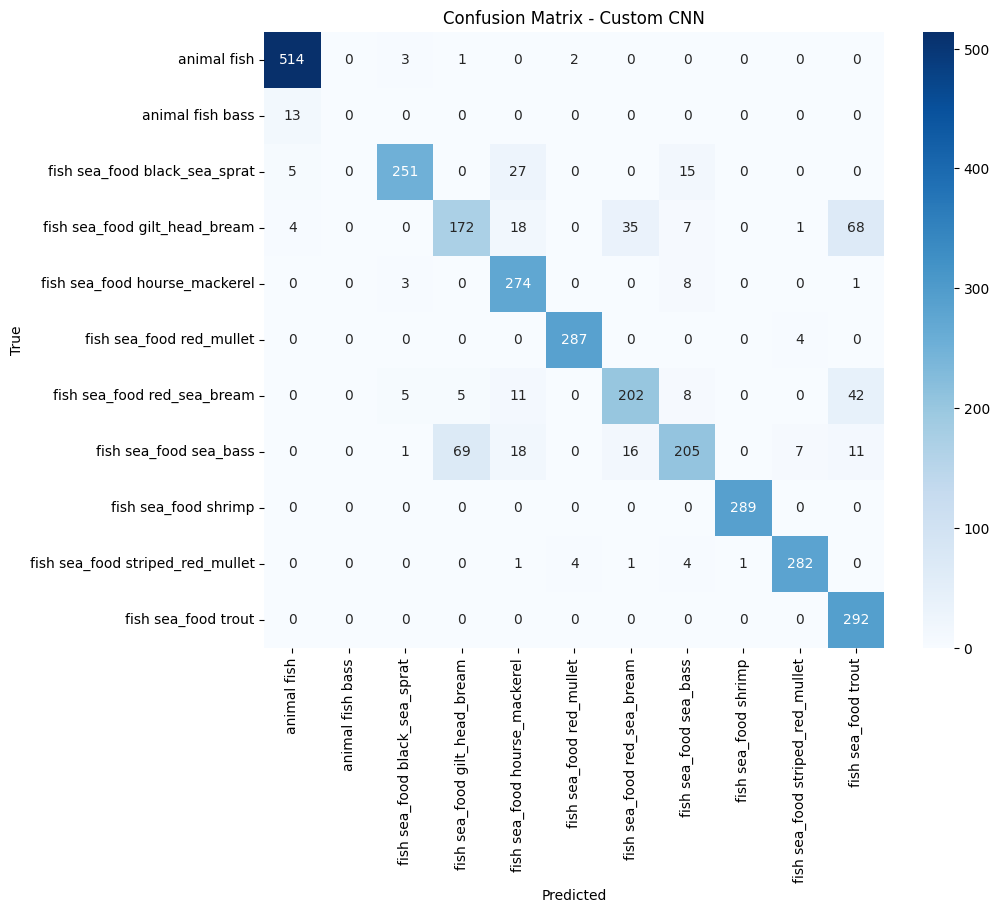


Evaluating VGG16 Transfer...


100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step
                                  precision    recall  f1-score   support

                     animal fish       0.97      0.98      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.93      0.96      0.95       298
   fish sea_food gilt_head_bream       0.94      0.90      0.92       305
   fish sea_food hourse_mackerel       0.80      0.97      0.88       286
        fish sea_food red_mullet       0.90      0.85      0.87       291
     fish sea_food red_sea_bream       0.91      0.96      0.93       273
          fish sea_food sea_bass       0.96      0.84      0.90       327
            fish sea_food shrimp       0.93      0.98      0.95       289
fish sea_food striped_red_mullet       0.83      0.80      0.81       293
             fish sea_food trout       0.99      0.96      0.97       292

                        accuracy                           0.92   

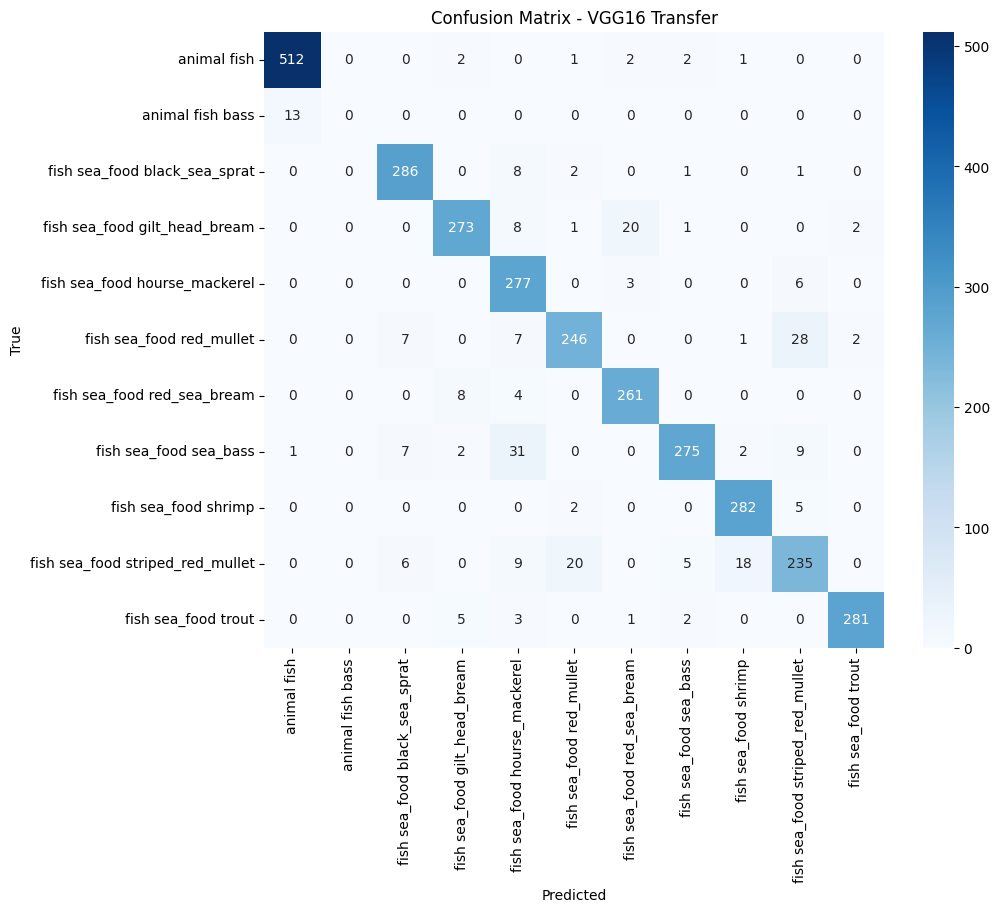


Evaluating ResNet50 Transfer...


100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step
                                  precision    recall  f1-score   support

                     animal fish       0.48      0.81      0.60       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.43      0.06      0.11       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.22      0.42      0.29       286
        fish sea_food red_mullet       0.24      0.35      0.28       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.42      0.45      0.44       289
fish sea_food striped_red_mullet       0.35      0.03      0.05       293
             fish sea_food trout       0.23      0.76      0.36       292

                        accuracy                           0.32   

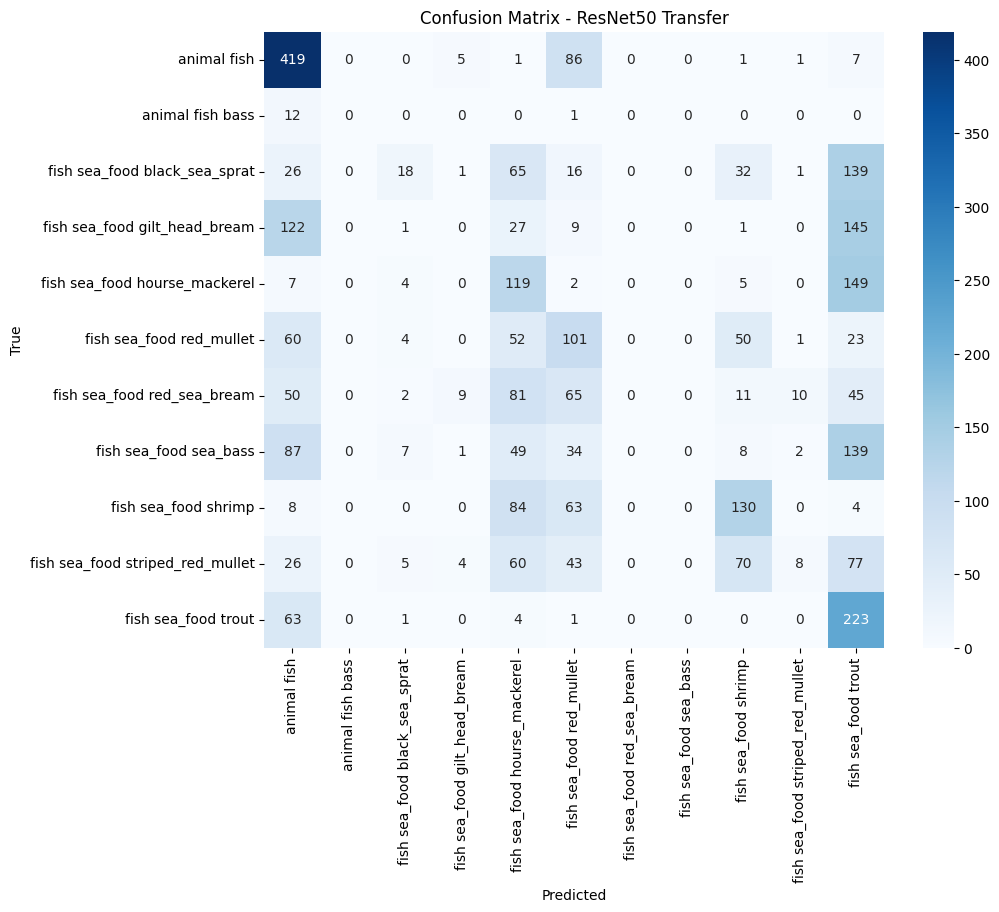


Evaluating MobileNet Transfer...


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step
                                  precision    recall  f1-score   support

                     animal fish       0.98      1.00      0.99       520
                animal fish bass       1.00      0.38      0.56        13
   fish sea_food black_sea_sprat       1.00      0.98      0.99       298
   fish sea_food gilt_head_bream       1.00      0.97      0.99       305
   fish sea_food hourse_mackerel       0.98      1.00      0.99       286
        fish sea_food red_mullet       0.97      0.97      0.97       291
     fish sea_food red_sea_bream       0.97      1.00      0.99       273
          fish sea_food sea_bass       0.99      0.99      0.99       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.97      0.96      0.97       293
             fish sea_food trout       0.99      1.00      1.00       292

                        accuracy                           0.99     

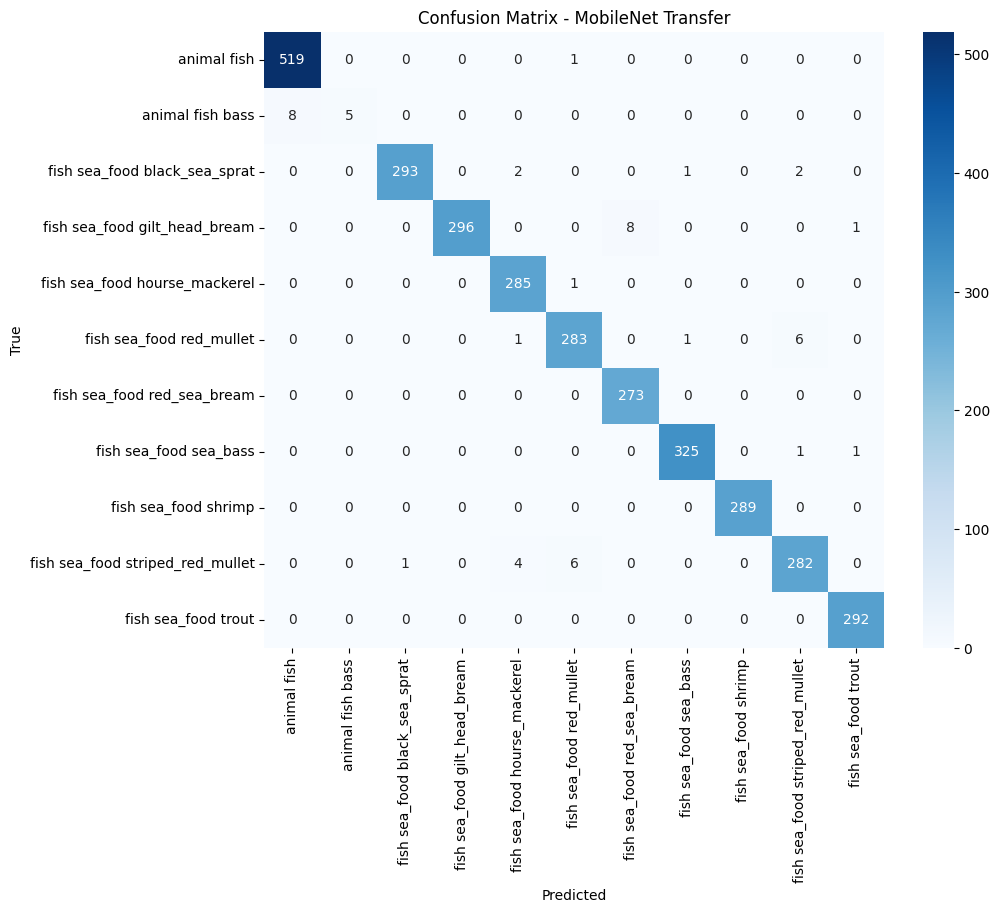


Evaluating InceptionV3 Transfer...


100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step
                                  precision    recall  f1-score   support

                     animal fish       0.97      0.99      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.92      0.99      0.96       298
   fish sea_food gilt_head_bream       0.95      0.95      0.95       305
   fish sea_food hourse_mackerel       0.97      0.94      0.96       286
        fish sea_food red_mullet       0.99      0.91      0.95       291
     fish sea_food red_sea_bream       0.95      1.00      0.97       273
          fish sea_food sea_bass       0.95      0.90      0.93       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.89      0.94      0.91       293
             fish sea_food trout       0.97      0.99      0.98       292

                        accuracy                           0.96   

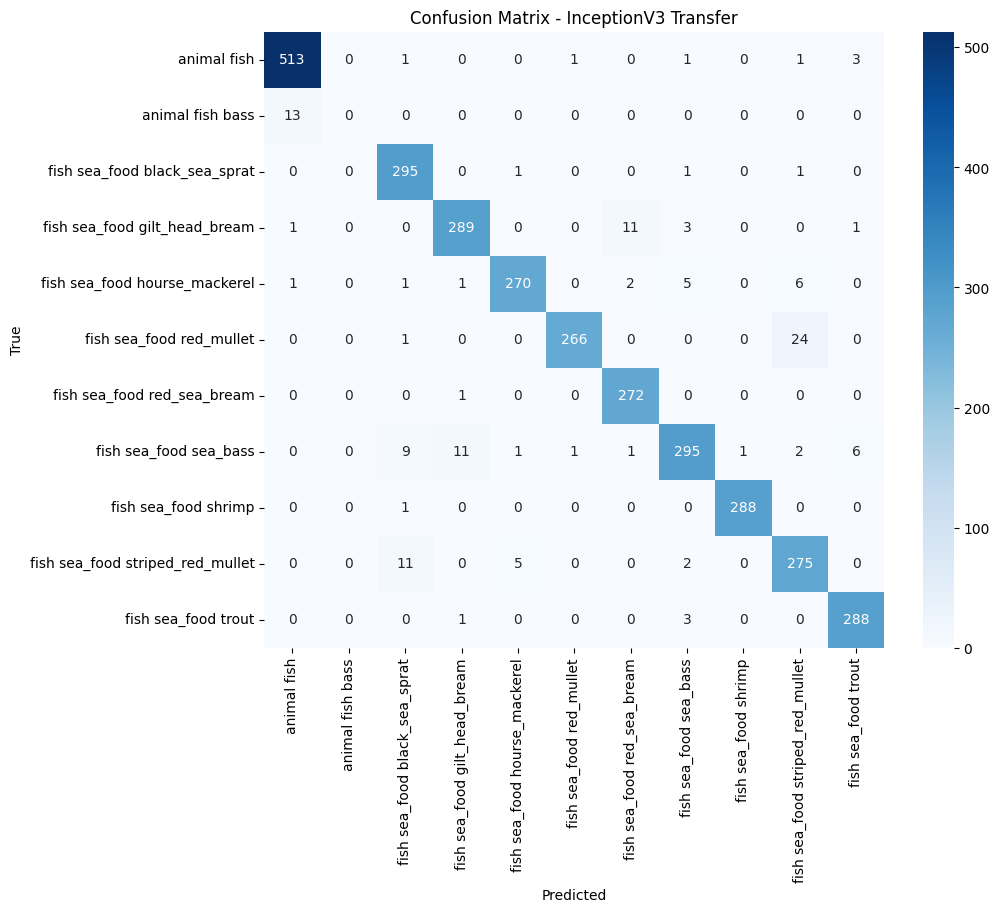


Evaluating EfficientNetB0 Transfer...


100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step
                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00      0.00       292

                        accuracy                           0.16   

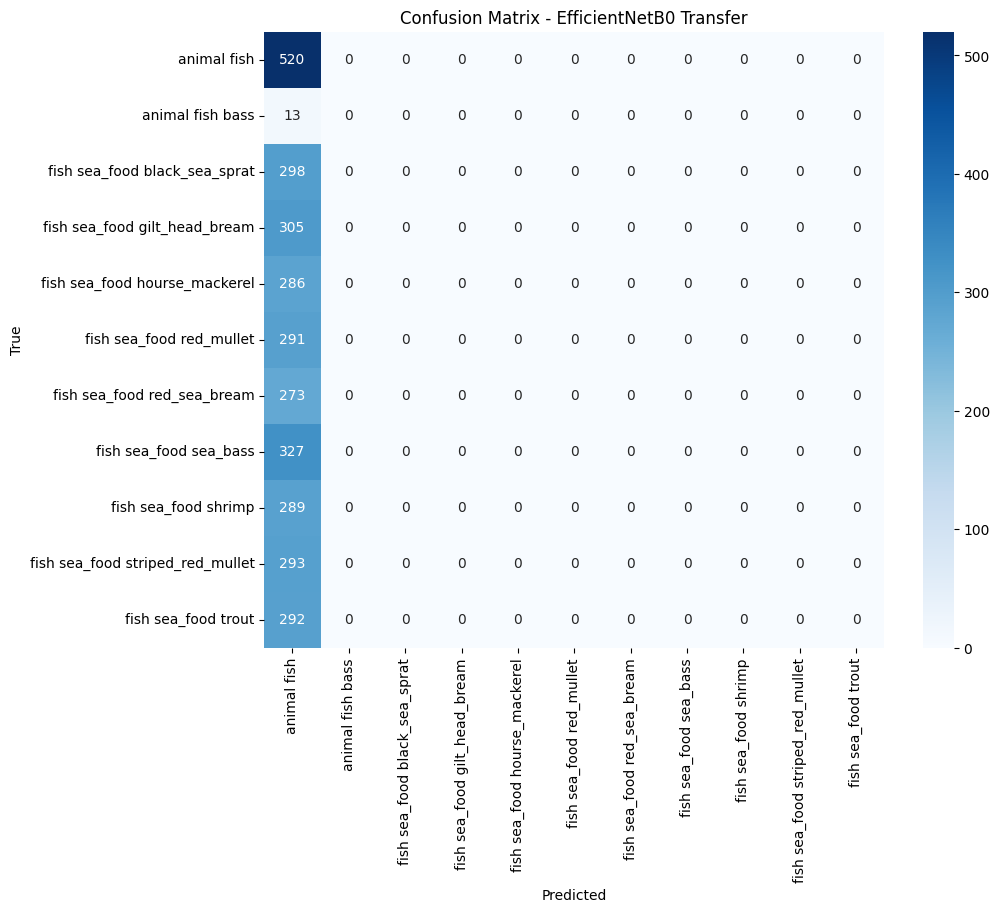


Comparison of Model Metrics:

                     Model  Accuracy  Precision    Recall  F1-Score
0               Custom CNN  0.868528   0.868695  0.868528  0.862941
1           VGG16 Transfer  0.918732   0.917609  0.918732  0.916716
2        ResNet50 Transfer  0.319423   0.251106  0.319423  0.236287
3       MobileNet Transfer  0.985880   0.986011  0.985880  0.985326
4     InceptionV3 Transfer  0.957327   0.954218  0.957327  0.955307
5  EfficientNetB0 Transfer  0.163163   0.026622  0.163163  0.045775


In [ ]:
model_paths = {
    "Custom CNN": "/content/drive/MyDrive/Labmentix Projects/3.Multi Class Fish Classification/custom_cnn.h5",
    "VGG16 Transfer": "/content/drive/MyDrive/Labmentix Projects/3.Multi Class Fish Classification/VGG16_transfer.h5",
    "ResNet50 Transfer": "/content/drive/MyDrive/Labmentix Projects/3.Multi Class Fish Classification/ResNet50_transfer.h5",
    "MobileNet Transfer": "/content/drive/MyDrive/Labmentix Projects/3.Multi Class Fish Classification/MobileNet_transfer.h5",
    "InceptionV3 Transfer": "/content/drive/MyDrive/Labmentix Projects/3.Multi Class Fish Classification/InceptionV3_transfer.h5",
    "EfficientNetB0 Transfer": "/content/drive/MyDrive/Labmentix Projects/3.Multi Class Fish Classification/EfficientNetB0_transfer.h5"
}

results = []

for model_name, path in model_paths.items():
    print(f"\nEvaluating {model_name}...")
    model = tf.keras.models.load_model(path)

    y_prob = model.predict(test_ds)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_true = np.argmax(y_true, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Create a summary DataFrame for all models
results_df = pd.DataFrame(results)
print("\nComparison of Model Metrics:\n")
print(results_df)